In [1]:
!pip install pygame
import numpy as np 
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
import pygame

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# ************************************ БАЗОВЫЙ АГЕНТ *****************************************

class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []


    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)


    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state 


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        state = int(state) 
        return np.argmax(self.Q[state])


    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:
            
            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)


    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()


    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass

# ************************************ SARSA *****************************************

class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state) 

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие 
                next_action = self.make_action(next_state) 
                
                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

# ************************************ Q-обучение *****************************************

class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде 
                action = self.make_action(state) 
                
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

# ************************************ Двойное Q-обучение *****************************************

class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return int(np.argmax(temp_q))


    def print_q(self):
        print('Вывод Q-матриц для алгоритма ', self.ALGO_NAME)
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)


    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде 
                action = self.make_action(state) 
                
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

In [3]:
def visualize(agent):
    env = agent.env
    state = agent.get_state(env.reset())
    done = False
    total_reward = 0

    # Визуализация игры
    pygame.init()
    clock = pygame.time.Clock()
    pygame.display.set_caption("Taxi-v3")
    screen_width, screen_height = 800, 600
    screen = pygame.display.set_mode((screen_width, screen_height))

    while not done:
        clock.tick(30)
        screen.fill((255, 255, 255))

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

        action = agent.greedy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = agent.get_state(next_state)

        env.render()
        pygame.display.flip()

    print("Total reward:", total_reward)
    env.close()
    pygame.quit()


In [14]:
def run_sarsa():
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
#     visualize(agent)


def run_q_learning():
    env = gym.make('Taxi-v3')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
#     visualize(agent)


def run_double_q_learning():
    env = gym.make('Taxi-v3')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
#     visualize(agent)   

100%|████████████████████████████████████| 20000/20000 [00:34<00:00, 586.81it/s]


Вывод Q-матрицы для алгоритма  Q-обучение
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 4.78067896  6.07784916  5.32521611  5.25302601  8.36234335 -2.12434565]
 [ 9.56665576 10.35800907 10.25323432 10.79683886 13.27445578  2.76367706]
 ...
 [-1.3661316  12.51807373 -1.15233424  0.11001912 -2.51246264 -3.26380487]
 [-1.4946399  -0.64096507 -2.45084599  8.40094738 -7.66502438 -6.80641733]
 [10.25218979 10.55092772 13.12937226 18.6         5.41673657  6.26475805]]


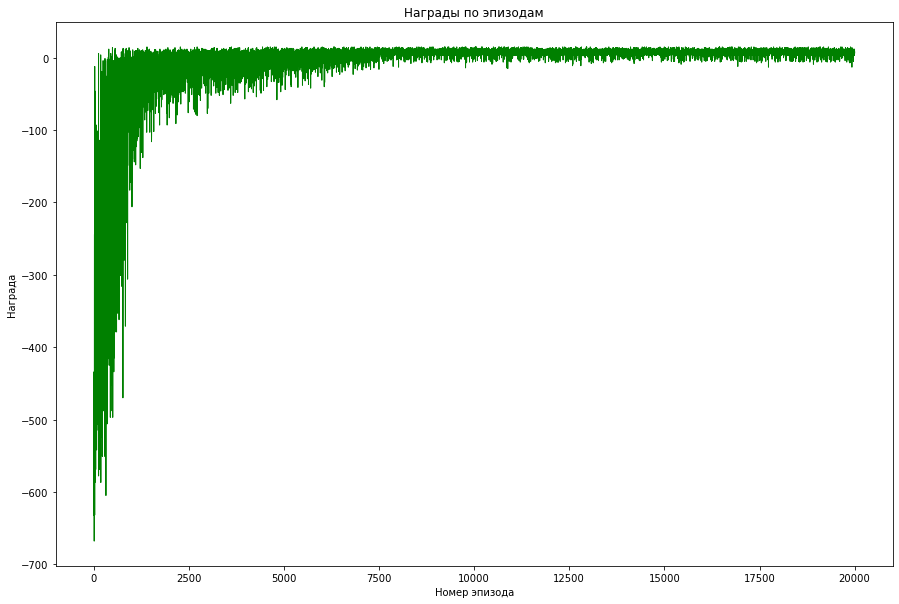

In [11]:
run_q_learning()

100%|████████████████████████████████████| 20000/20000 [00:33<00:00, 604.33it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.0159585   -6.90951548  -7.81824152  -2.86503494   7.81426553
  -14.47259915]
 [ -0.69255287   0.29954327   1.13429665   2.08444342  13.05873246
   -1.29328843]
 ...
 [  2.44817005  11.31820418   0.19422203  -2.46967956  -7.31936865
   -9.53142616]
 [ -7.46588378  -6.31622174  -7.92353676  -7.84515501 -13.46745397
  -12.80610306]
 [  3.46502874   1.21740417   0.64373809  17.94690317  -2.78822324
   -3.03276591]]


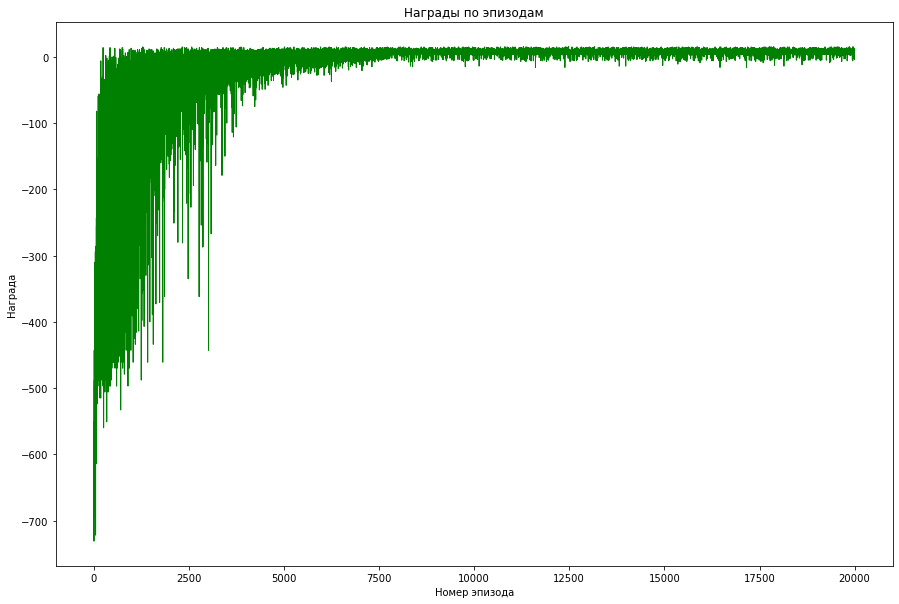

In [15]:
run_sarsa()

100%|████████████████████████████████████| 20000/20000 [00:55<00:00, 359.58it/s]


Вывод Q-матриц для алгоритма  Двойное Q-обучение
Q1
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.30139928 -0.15825928 -1.04072565  2.61962212  8.36234335 -5.68233932]
 [ 6.7372333   6.57679452  3.62483404  8.16850889 13.27445578 -0.75749276]
 ...
 [ 6.4899794  14.5657712  10.95414663  9.2006219   1.12989979  2.33966787]
 [-3.61457119  3.12101333 -3.32608149 -2.11440654 -6.28336376 -4.01025021]
 [-0.5471558  -0.20862     1.08380082 18.33745316 -1.          1.00973847]]
Q2
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.14198787 -0.03450055  0.34852149  2.07454118  8.36234335 -5.54336954]
 [ 4.12786927  4.94263815  3.29909849  8.16797463 13.27445578 -1.29382354]
 ...
 [ 6.49474872 14.5657712   6.27114457  4.92440416  2.10768634  3.09312058]
 [-3.56755536  2.66278752 -3.73895177 -4.06657093 -6.15241094 -5.87472497]
 [ 6.28148274  2.20820727  4.81184672 18.44419156 -0.76127927 -0.61641958]]


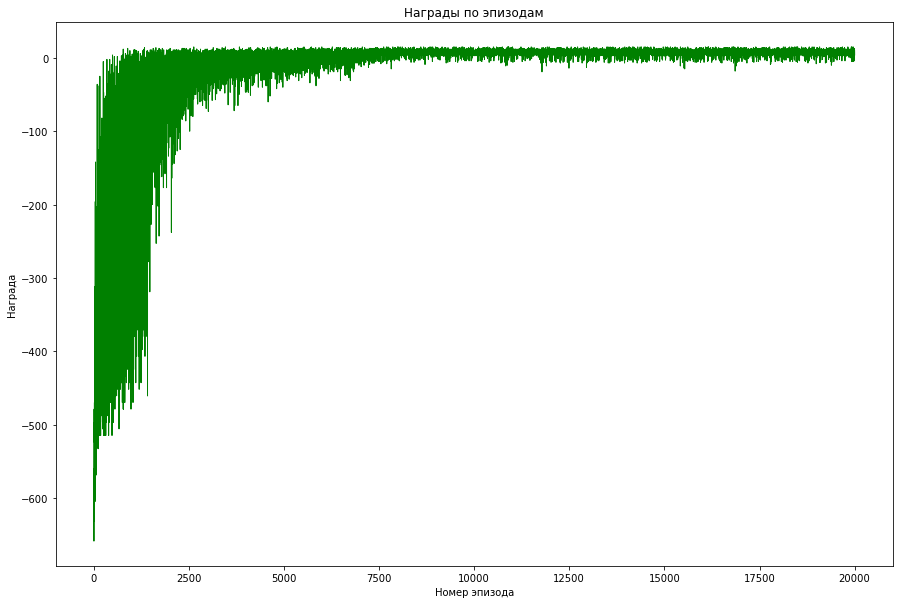

In [9]:
run_double_q_learning()